In [329]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from datetime import datetime, timedelta
import seaborn as sns
import random

In [330]:
data = pd.read_csv('nasdaq2007_17.csv', sep = '\t', header=None, index_col = 0)
data.index.name = None
data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3611,3612,3613,3614,3615,3616,3617,3618,3619,3620,3621,3622,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649,3650
a,11.1440,10.4710,10.8280,10.6980,10.9100,10.9760,11.5770,11.9130,11.9060,12.2380,12.6430,12.8600,13.4410,13.2640,13.0360,12.6840,12.690,12.7520,12.7170,12.7710,12.9870,12.9870,13.2050,13.0010,12.8660,12.7520,12.6570,12.7710,13.0610,13.1980,13.1980,13.4410,13.7020,13.4930,14.372,14.6350,14.6940,14.2160,14.6470,14.9520,...,65.946,66.036,65.956,65.787,65.647,64.599,63.980,64.26,63.8500,64.07,64.87,65.15,65.83,65.70,66.360,66.56,66.60,66.62,67.54,66.99,66.91,66.12,66.44,66.88,67.25,67.02,67.32,67.39,67.71,67.97,67.49,68.03,68.02,68.13,68.37,68.22,68.25,68.11,67.47,66.81
aa,47.4580,45.8700,46.2490,47.8520,49.5240,49.7790,50.9660,50.8400,50.1720,51.3840,52.8290,52.3440,54.2480,53.9490,54.1400,53.2420,54.183,54.4540,54.5740,53.4090,54.8710,55.5370,55.5370,55.0160,54.7880,52.3440,52.1200,51.1780,52.7000,52.3860,53.2420,53.2420,53.3040,52.8290,53.681,53.8870,53.1770,52.0970,52.7640,52.4240,...,44.910,46.200,47.500,46.250,45.380,45.290,44.740,45.07,46.0800,46.62,47.65,48.31,47.91,48.25,47.490,47.07,46.89,46.94,47.53,47.71,48.24,47.77,47.75,46.54,47.93,47.93,50.08,49.52,49.15,47.91,47.42,47.78,47.70,47.46,47.12,47.29,46.97,45.89,43.33,43.01
aaba,13.8800,12.9700,13.2900,13.0900,13.4500,14.2400,14.9800,14.9500,15.0700,14.9200,14.3300,14.2800,14.7900,14.7000,13.9700,13.7500,13.950,14.8000,14.8500,14.3600,15.3300,15.7100,16.1500,15.8100,16.0700,15.7600,15.6800,15.6800,16.4300,16.1100,16.3500,16.8200,17.1800,17.4300,17.640,17.5500,17.6400,16.2800,16.0900,16.1000,...,67.110,67.430,66.920,66.590,67.340,64.960,64.450,65.80,65.5803,66.24,66.51,67.81,67.66,67.72,67.850,68.74,68.93,69.22,67.91,67.52,68.04,66.78,67.79,67.45,67.51,66.51,66.61,65.40,65.57,67.52,68.86,70.12,70.59,70.51,70.23,71.71,72.22,71.16,70.19,70.56
aapl,1.2037,1.1589,1.1385,1.1437,1.1679,1.1731,1.2089,1.1704,1.1589,1.1487,1.1167,1.1078,1.1271,1.1294,1.0974,1.0744,1.100,1.1167,1.1371,1.1153,1.1691,1.1655,1.2241,1.2254,1.2294,1.2204,1.2026,1.2217,1.2347,1.1999,1.2204,1.2217,1.2334,1.2241,1.273,1.3065,1.2743,1.2540,1.2717,1.2743,...,158.100,158.160,155.510,152.840,151.350,150.010,152.590,153.68,152.7300,153.57,153.26,153.92,152.93,154.83,154.740,155.28,155.34,155.99,155.44,156.43,159.31,159.90,159.19,155.42,155.69,155.61,156.54,155.85,156.85,162.47,166.12,168.43,166.29,167.51,171.88,173.63,174.18,175.61,175.25,174.67
abc,13.9910,13.4340,13.1950,13.4150,13.4710,13.4250,13.5920,13.7040,13.8990,14.2500,14.2450,14.2220,14.4960,15.2040,15.6960,15.1270,15.213,15.3580,15.3690,15.0610,15.6620,15.8540,15.6270,15.4360,15.9410,15.5330,15.4170,15.6140,15.9140,15.8410,15.7660,15.9410,16.1960,16.1830,16.665,16.4110,16.1550,15.6910,15.7850,15.7940,...,80.670,79.280,79.500,80.380,81.050,80.980,82.000,82.43,80.9900,82.75,83.30,82.88,82.74,84.12,80.480,78.35,79.55,80.32,80.80,79.44,79.00,79.95,80.49,82.20,83.21,82.53,81.85,82.22,78.77,76.38,76.93,76.95,76.62,73.23,74.80,74.86,74.91,75.01,75.27,75.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xray,17.2850,16.9010,17.0160,17.4210,17.8650,17.6130,17.9420,17.8350,17.8750,18.0180,18.1530,18.2490,18.6540,18.6920,18.3940,18.6070,18.885,19.3660,19.3660,18.8660,19.5010,19.3660,19.4140,19.0670,19.4040,19.2610,19.2610,19.1450,19.4430,19.4620,19.7210,19.8000,19.7500,19.7500,20.406,20.6480,20.5120,20.5310,21.0990,21.2840,...,58.622,57.763,58.562,57.723,58.442,59.071,59.460,59.68,59.2300,59.81,56.33,55.65,57.21,58.98,58.510,58.09,57.57,57.32,58.41,58.22,59.19,59.50,59.50,60

In [331]:
def get_time_series(data, index, anomalize = True):
  ts = pd.DataFrame()
  ts ['value'] = data.iloc[[index]].transpose().iloc[:,0]
  ts['date'] = pd.date_range('2007-01-01', periods=ts.shape[0]).tolist()
  if anomalize:
    ts['value'][3000:3002] = 100
  ts = ts.set_index('date')
  return ts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


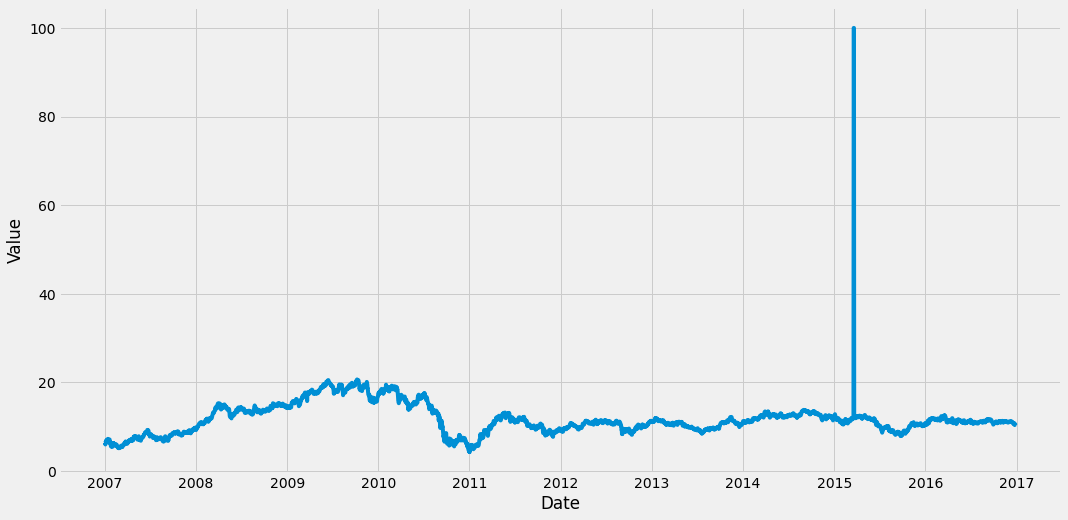

In [332]:
ts = get_time_series(data, 16)
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')
plt.plot(ts['value'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [333]:
train_size = int(len(ts) * 0.7)

train, test = ts.iloc[:train_size], ts.iloc[train_size:]
print(train.shape, test.shape)

(2555, 1) (1095, 1)


In [334]:
scaler = MinMaxScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [335]:
def create_dataset(x, y, lookback=1):
    x_ts = []
    y_ts = []

    for i in range(len(x) - lookback):
        v = x.iloc[i:(i + lookback)].values
        x_ts.append(v)
        y_ts.append(y.iloc[i + lookback])
    return np.array(x_ts), np.array(y_ts)

In [336]:
lookback = 30

x_train, y_train = create_dataset(train[['value']], train['value'], lookback)
x_test, y_test = create_dataset(test[['value']], test['value'], lookback)

In [337]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=x_train.shape[1]))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(x_train.shape[2])))
model.compile(optimizer='adam', loss='mae')

In [338]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
71/71 [==============================] - 7s 49ms/step - loss: 0.1028 - val_loss: 0.0351
Epoch 2/10
71/71 [==============================] - 2s 35ms/step - loss: 0.0794 - val_loss: 0.0277
Epoch 3/10
71/71 [==============================] - 2s 34ms/step - loss: 0.0659 - val_loss: 0.0254
Epoch 4/10
71/71 [==============================] - 2s 35ms/step - loss: 0.0579 - val_loss: 0.0243
Epoch 5/10
71/71 [==============================] - 2s 35ms/step - loss: 0.0559 - val_loss: 0.0231
Epoch 6/10
71/71 [==============================] - 3s 37ms/step - loss: 0.0546 - val_loss: 0.0232
Epoch 7/10
71/71 [==============================] - 3s 46ms/step - loss: 0.0521 - val_loss: 0.0215
Epoch 8/10
71/71 [==============================] - 3s 39ms/step - loss: 0.0513 - val_loss: 0.0203
Epoch 9/10
71/71 [==============================] - 3s 38ms/step - loss: 0.0532 - val_loss: 0.0203
Epoch 10/10
71/71 [==============================] - 3s 37ms/step - loss: 0.0510 - val_loss: 0.0216


In [339]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

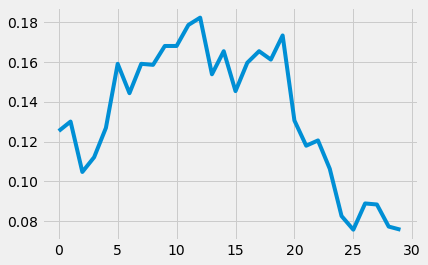

In [340]:
plt.plot(x_train[1])

In [341]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

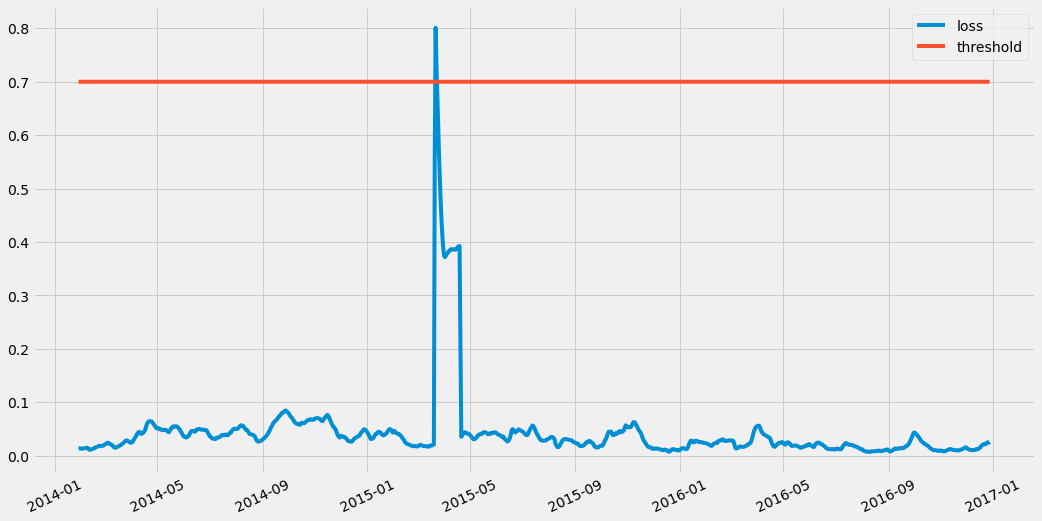

In [342]:
threshold = 0.7

test_score_df = pd.DataFrame(index=test[lookback:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['value'] = test[lookback:].value
test_score_df

plt.figure(figsize=(16, 8))
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


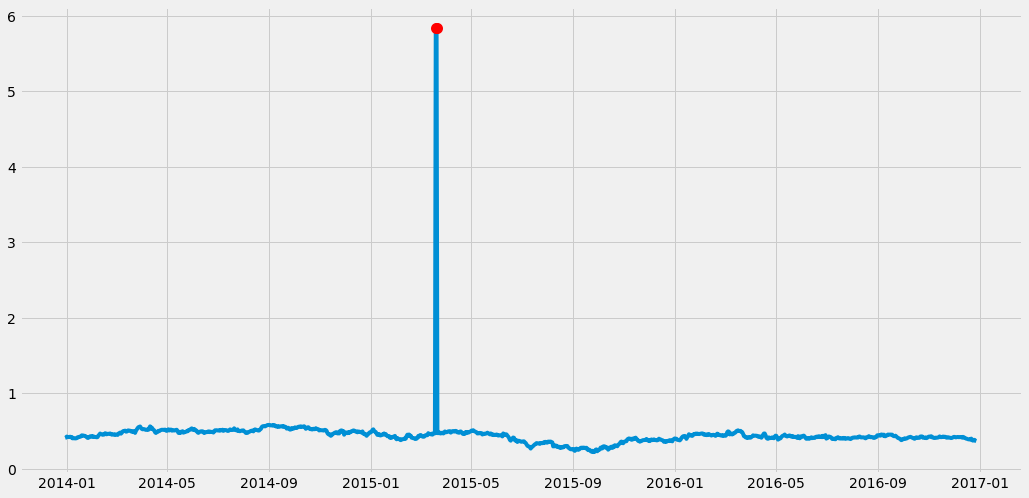

In [344]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.reindex()


corrected_dates = []

for date in anomalies.index:
  day_before = (date- timedelta(days=2)).date()
  corrected_dates.append(day_before)
  anomalies.loc[date, 'value'] = test.loc[str(day_before), 'value']

anomalies.index = corrected_dates

plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')
plt.plot(test['value'], zorder=1)
plt.scatter(anomalies.index, anomalies['value'], color = 'red', linewidths=5, zorder=2)
plt.show()

